### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Heart Failure Prediction Dataset
Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("HeartFailureData_50_50_PCA_KNN_predictions.csv")

print(knn_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.935632       1
1    1       1  0.718133       1
2    1       1  0.947130       1
3    1       1  0.379473       0
4    0       0  0.238673       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["Sex"].values

# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_knn = gender_knn

print("Example rows:\n", knn_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.935632       1
1    1       1  0.718133       1
2    1       1  0.947130       1
3    1       1  0.379473       0
4    0       0  0.238673       0


In [5]:
# protected_attr = Sex column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EOD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EOD - KNN
Demographic Parity Difference: 0.4380
Equalized Odds Difference: 0.1875


## Fairness Metrics – KNN

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the KNN model.  

### Results
- **Demographic Parity Difference (DPD): 0.4380**  
- **Equalized Odds Difference (EOD): 0.1875**

---

### Interpretation

- **DPD (0.438):**  
  This high value indicates a **large disparity in outcome distribution** between genders. Specifically, **males (privileged group) receive positive predictions much more often than females (unprivileged group)**. This demonstrates a strong **disparate impact against females**.  

- **EOD (0.188):**  
  A relatively high equalized odds difference suggests **substantial imbalance in error rates** (true positive and false positive rates) between genders. This means that the model’s **sensitivity and error distribution differ significantly between males and females**, indicating unequal treatment in prediction performance.  

---

### Conclusion

The KNN model shows **serious fairness concerns**:  
- It **favors males** in terms of outcome access (high DPD), meaning females are less likely to receive positive predictions.  
- It also introduces **unequal error behavior across genders (high EOD)**, suggesting the model is less consistent in how it classifies positive and negative cases for females compared to males.  

In summary, the KNN model demonstrates **both outcome bias and error-rate bias**.

---

In [6]:
# MetricFrame for extended analysis
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.894737   0.666667  0.666667  0.666667        0.157895   
1                    0.869863   0.942529  0.854167  0.896175        0.595890   

                          tpr     fpr     tnr       fnr  
sensitive_feature_0                                      
0                    0.666667  0.0625  0.9375  0.333333  
1                    0.854167  0.1000  0.9000  0.145833  


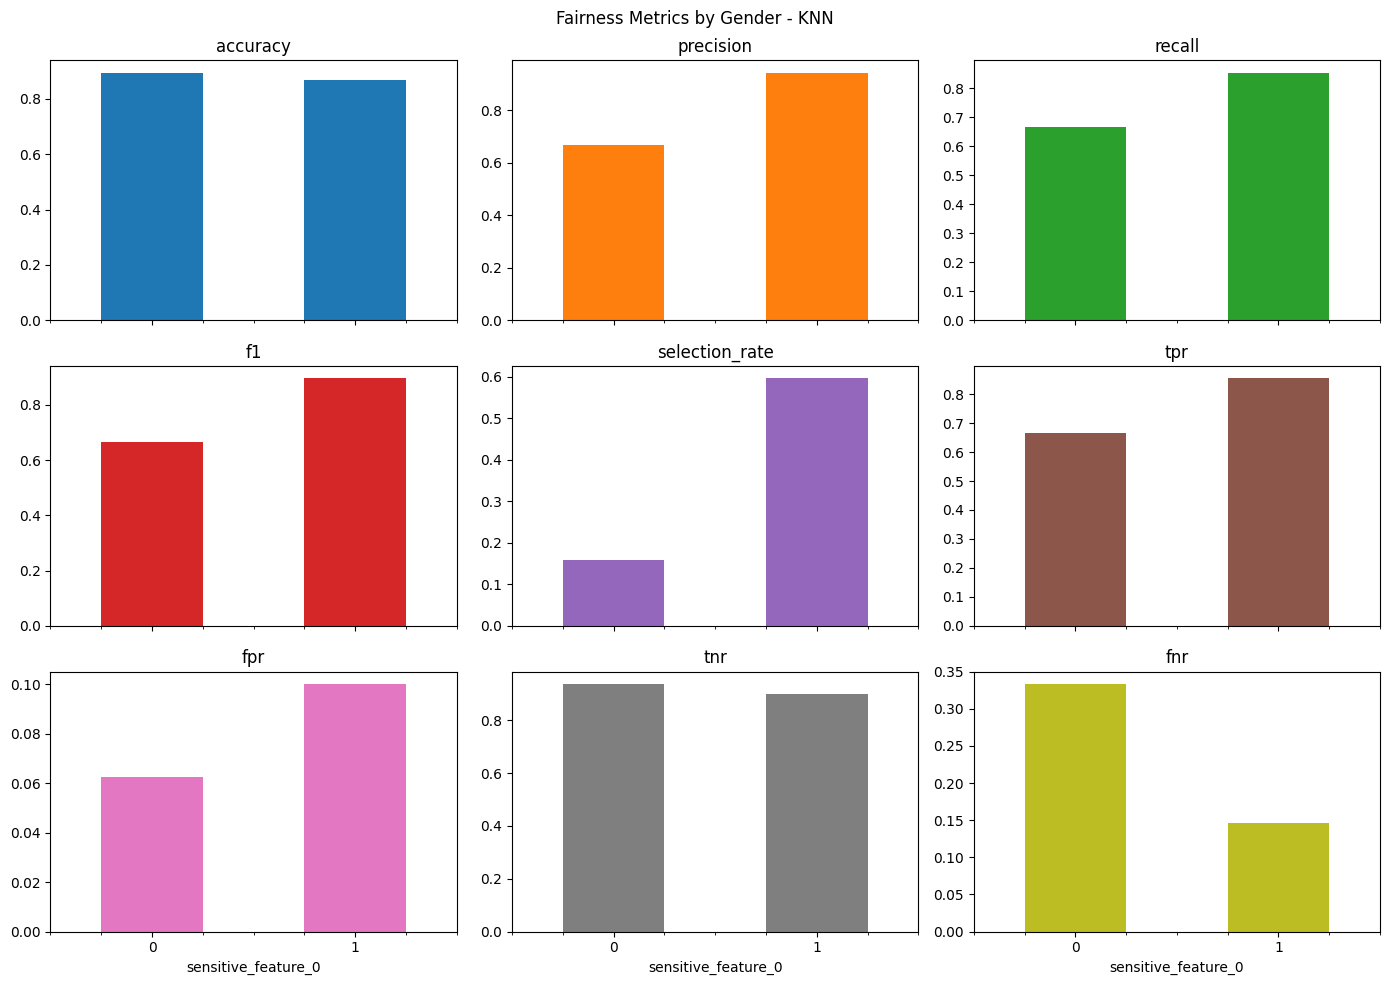


Between-group differences (max group − min group):
accuracy          0.024874
precision         0.275862
recall            0.187500
f1                0.229508
selection_rate    0.437996
tpr               0.187500
fpr               0.037500
tnr               0.037500
fnr               0.187500
dtype: float64

Between-group ratios (min / max):
accuracy          0.972200
precision         0.707317
recall            0.780488
f1                0.743902
selection_rate    0.264973
tpr               0.780488
fpr               0.625000
tnr               0.960000
fnr               0.437500
dtype: float64

Disparate Impact Ratio (selection rate): 0.2650
Equality of Opportunity Difference (TPR gap): 0.1875


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

## Fairness Metrics by Gender – KNN

This section analyzes the fairness of the **KNN classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8947     | 0.8699   |
| Precision        | 0.6667     | 0.9425   |
| Recall (Sensitivity) | 0.6667 | 0.8542   |
| F1 Score         | 0.6667     | 0.8962   |
| Selection Rate   | 0.1579     | 0.5959   |
| True Positive Rate (TPR) | 0.6667 | 0.8542 |
| False Positive Rate (FPR) | 0.0625 | 0.1000 |
| True Negative Rate (TNR) | 0.9375 | 0.9000 |
| False Negative Rate (FNR) | 0.3333 | 0.1458 |

---

### Between-Group Disparities

- **Precision Gap (0.28):** Males’ positive predictions are far more reliable.  
- **Recall/TPR Gap (0.19):** Females are less likely to be correctly identified as positive.  
- **F1 Gap (0.23):** Overall predictive quality is substantially higher for males.  
- **Selection Rate Gap (0.44):** Males are nearly **4x more likely** to receive positive predictions.  
- **FNR Gap (0.19):** Females suffer higher missed positive cases (33% vs. 15%).  
- **FPR/TNR Gaps (~0.04):** Differences are smaller, but males face slightly more false positives.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.972 |
| Precision                 | 0.707 |
| Recall                    | 0.780 |
| F1 Score                  | 0.744 |
| Selection Rate            | 0.265 |
| TPR                       | 0.780 |
| FPR                       | 0.625 |
| TNR                       | 0.960 |
| FNR                       | 0.438 |

- **Selection Rate Ratio = 0.265 (< 0.8 rule)** → Very strong **disparate impact** against females.  
- **Recall/TPR Ratio = 0.78** → Females are detected less often when truly positive.  
- **Precision Ratio = 0.71** → Female positive predictions are less trustworthy.  
- **FPR Ratio (0.63)** → Indicates males are more prone to false positives.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.2650**  
  → Females are much less likely to receive positive predictions compared to males.  

- **Equality of Opportunity Difference (TPR gap): 0.1875**  
  → Substantial gap in sensitivity, disadvantaging females.  

---

### Interpretation

The **KNN model strongly favors males**:  
- They receive more positive predictions, which are also more precise and balanced (higher F1).  
- Females are disadvantaged, with **low selection rates, lower recall, and more missed positive cases**.  
- While error rates on negatives (FPR/TNR) are more balanced, the **main fairness concern lies in outcome access and sensitivity gaps**.  

**Conclusion:**  
KNN demonstrates **systematic bias against females**, producing both **outcome bias (low selection rate)** and **error-rate bias (large TPR/FNR gaps)**. This aligns with the earlier high **DPD (0.438)** and **EOD (0.188)**, confirming that KNN is spreading inequality.

---

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.953125
1                    0.918125

KNN - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.070569
1                    0.113264


## Group-Specific ROC-AUC and Brier Score – KNN

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the KNN model across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9531     | 0.9181   |
| Brier Score   | 0.0706     | 0.1133   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Both genders achieve strong discrimination ability (>0.90).  
  - Females (0.953) outperform males (0.918), meaning the model is **better at ranking positive vs. negative cases for females**.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.071) achieve a much lower Brier score than males (0.113).  
  - This indicates that **probability estimates are more reliable and better calibrated for females**, whereas predictions for males are less consistent.  

---

### Conclusion

Although earlier fairness metrics showed that **males are favored in outcome access (selection rate, precision, F1)**, the **probability-based evaluation (ROC-AUC, Brier)** reveals the opposite trend:  
- **Females benefit from higher-quality probability predictions** with better discrimination and calibration.  
- **Males, despite being the majority group (75% in training), receive more positive classifications, but with less reliable probability estimates.**  

This highlights the **fairness trade-off in KNN**:  
- **Outcome bias favors males**, while  
- **Probability quality favors females**.

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("HeartFailureData_50_50_AltTunedDT_predictions.csv")
print(dt_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  1.000000       1
1    1       1  0.000000       0
2    1       1  1.000000       1
3    1       1  0.272727       0
4    0       0  1.000000       1


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred"].values
gender_dt = dt_df["Sex"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print("Example rows:\n", dt_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  1.000000       1
1    1       1  0.000000       0
2    1       1  1.000000       1
3    1       1  0.272727       0
4    0       0  1.000000       1


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.3306
Equalized Odds Difference: 0.1042


## Fairness Metrics – Decision Tree (DT)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the Decision Tree model.  

### Results
- **Demographic Parity Difference (DPD): 0.3306**  
- **Equalized Odds Difference (EOD): 0.1042**

---

### Interpretation

- **DPD (0.331):**  
  This indicates a **noticeable disparity in positive outcome distribution** between genders. Males (privileged group) are more likely to receive positive predictions than females (unprivileged group). Such an imbalance reflects **disparate impact** against females, limiting their access to favorable predictions.  

- **EOD (0.104):**  
  The equalized odds difference suggests a **moderate imbalance in error rates** (true positive rate and false positive rate) across genders. This means that the model’s classification performance is not equally distributed, and one gender experiences different error rates than the other.  

---

### Conclusion

The Decision Tree introduces **two forms of fairness concerns**:  
1. **Outcome imbalance (DPD):** females are disadvantaged in terms of receiving positive predictions.  
2. **Error-rate imbalance (EOD):** prediction errors are distributed unequally across genders.  

Together, these results highlight that the DT model is **biased against females both in outcome access and in classification consistency**.

---


DT - Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.842105   0.500000  0.666667  0.571429        0.210526   
1                    0.815068   0.936709  0.770833  0.845714        0.541096   

                          tpr    fpr    tnr       fnr  
sensitive_feature_0                                    
0                    0.666667  0.125  0.875  0.333333  
1                    0.770833  0.100  0.900  0.229167  


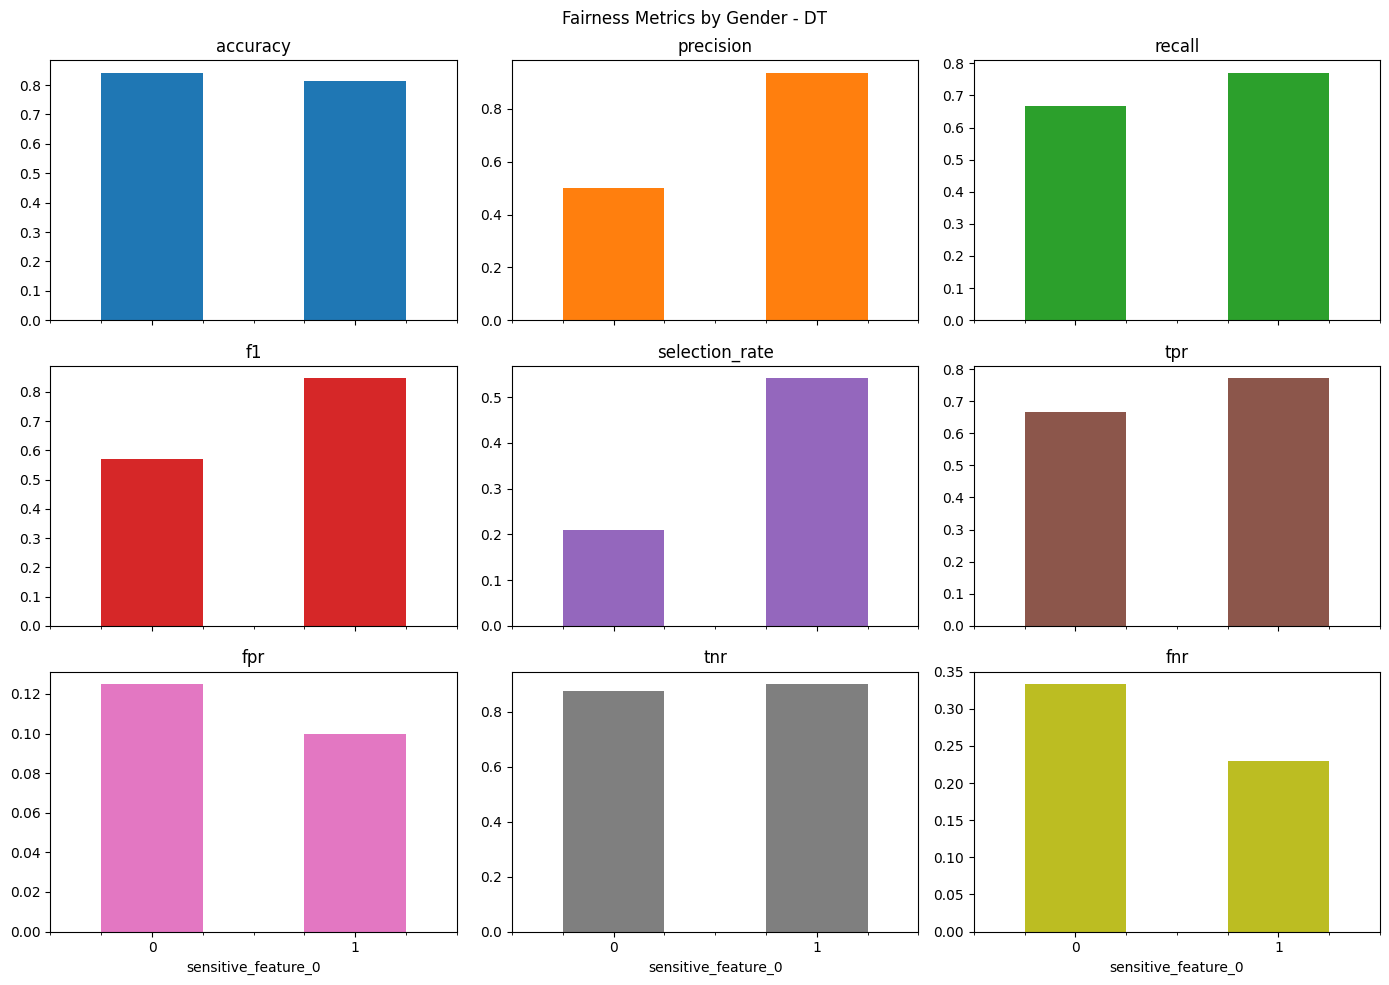


Between-group differences (max group − min group):
accuracy          0.027037
precision         0.436709
recall            0.104167
f1                0.274286
selection_rate    0.330570
tpr               0.104167
fpr               0.025000
tnr               0.025000
fnr               0.104167
dtype: float64

Between-group ratios (min / max):
accuracy          0.967894
precision         0.533784
recall            0.864865
f1                0.675676
selection_rate    0.389074
tpr               0.864865
fpr               0.800000
tnr               0.972222
fnr               0.687500
dtype: float64

Disparate Impact Ratio (selection rate): 0.3891
Equality of Opportunity Difference (TPR gap): 0.1042


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT - Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

## Fairness Metrics by Gender – Decision Tree (DT)

This section analyzes the fairness of the **Decision Tree classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8421     | 0.8151   |
| Precision        | 0.5000     | 0.9367   |
| Recall (Sensitivity) | 0.6667 | 0.7708   |
| F1 Score         | 0.5714     | 0.8457   |
| Selection Rate   | 0.2105     | 0.5411   |
| True Positive Rate (TPR) | 0.6667 | 0.7708 |
| False Positive Rate (FPR) | 0.1250 | 0.1000 |
| True Negative Rate (TNR) | 0.8750 | 0.9000 |
| False Negative Rate (FNR) | 0.3333 | 0.2292 |

---

### Between-Group Disparities

- **Precision Gap (0.44):** Males’ positive predictions are much more reliable.  
- **Recall/TPR Gap (0.10):** Females are less likely to be correctly identified when positive.  
- **F1 Gap (0.27):** Overall predictive quality is significantly higher for males.  
- **Selection Rate Gap (0.33):** Males are more than **2.5 times as likely** to receive positive predictions.  
- **FNR Gap (0.10):** Females suffer more missed positive cases (33% vs. 23%).  
- **FPR/TNR Gaps (0.025 each):** Error rates for negatives are fairly close between genders.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.968 |
| Precision                 | 0.534 |
| Recall                    | 0.865 |
| F1 Score                  | 0.676 |
| Selection Rate            | 0.389 |
| TPR                       | 0.865 |
| FPR                       | 0.800 |
| TNR                       | 0.972 |
| FNR                       | 0.688 |

- **Selection Rate Ratio = 0.389 (< 0.8 rule)** → Indicates strong **disparate impact** against females.  
- **Precision Ratio = 0.53** → Female positive predictions are far less precise.  
- **Recall/TPR Ratio = 0.87** → Females are less likely to be detected when positive.  
- **FPR/TNR Ratios (~0.80–0.97)** → Negative classification errors are nearly balanced.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.3891**  
  → Females are far less likely to receive positive predictions.  

- **Equality of Opportunity Difference (TPR gap): 0.1042**  
  → Moderate disparity in sensitivity, with females disadvantaged.  

---

### Interpretation

The **Decision Tree model favors males** in multiple dimensions:  
- They receive more positive predictions, and these predictions are more reliable (higher precision, F1).  
- Females are disadvantaged with lower recall/TPR, more missed positives, and far fewer positive outcomes.  
- While error rates on negatives (FPR, TNR) are relatively close, the **main fairness concerns** are the **outcome imbalance (selection rate)** and **predictive quality gaps (precision, F1)**.  

**Conclusion:**  
The DT model demonstrates **systematic bias against females**, particularly in **positive outcome access and classification reliability**, even though its treatment of negatives is relatively balanced.

---

In [13]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.815104
1                    0.878646

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.143083
1                    0.143341


## Group-Specific ROC-AUC and Brier Score – Decision Tree (DT)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the Decision Tree across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.8151     | 0.8786   |
| Brier Score   | 0.1431     | 0.1433   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Males (0.879) achieve higher ROC-AUC compared to females (0.815).  
  - This means the DT is **better at distinguishing positives from negatives for males**, while its discrimination ability for females is weaker.  

- **Brier Score (Calibration Quality):**  
  - Both groups show almost identical Brier scores (~0.143).  
  - This suggests that **probability estimates are equally calibrated** across genders, with no meaningful difference in reliability of predicted probabilities.  

---

### Conclusion

The Decision Tree exhibits a **gender gap in discrimination ability (ROC-AUC)**, favoring males, while **probability calibration (Brier score) is essentially equal** across groups.  
This indicates that although predictions are **equally well-calibrated for both genders**, the model is **more effective at ranking outcomes for males than for females**.

--

### Bias detection for the Random Forest Model

In [14]:
rf_df = pd.read_csv("HeartFailureData_50_50_RF_predictions.csv")
print(rf_df.head())

   Sex  y_true  y_prob  y_pred
0    1       1    0.96       1
1    1       1    0.19       0
2    1       1    0.97       1
3    1       1    0.31       0
4    0       0    0.37       0


In [15]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["Sex"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print("Example rows:\n", rf_df.head())

Example rows:
    Sex  y_true  y_prob  y_pred
0    1       1    0.96       1
1    1       1    0.19       0
2    1       1    0.97       1
3    1       1    0.31       0
4    0       0    0.37       0


In [16]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.3464
Equalized Odds Difference: 0.0237


## Fairness Metrics – Random Forest (RF)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the Random Forest model.  

### Results
- **Demographic Parity Difference (DPD): 0.3464**  
- **Equalized Odds Difference (EOD): 0.0237**

---

### Interpretation

- **DPD (0.346):**  
  This value reflects a **substantial imbalance in outcome distribution** between genders. Males (privileged group) are significantly more likely to receive positive predictions compared to females (unprivileged group). This points to **disparate impact against females**, limiting their access to favorable outcomes.  

- **EOD (0.024):**  
  The very small equalized odds difference indicates that **error rates (true positive rate and false positive rate) are nearly equal across genders**. In other words, once predictions are made, the model treats males and females similarly in terms of classification performance.  

---

### Conclusion

The Random Forest model presents a **mixed fairness profile**:  
- It shows **bias in outcome distribution (DPD)**, disadvantaging females in terms of positive prediction rates.  
- However, it achieves **high fairness in error distribution (low EOD)**, meaning predictive accuracy and misclassification patterns are consistent across genders.  

This highlights that while RF is **unfair in outcome access**, it remains **balanced in how it handles classification errors** across groups.

--


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.842105   0.500000  0.833333  0.625000        0.263158   
1                    0.828767   0.898876  0.833333  0.864865        0.609589   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.833333  0.15625  0.84375  0.166667  
1                    0.833333  0.18000  0.82000  0.166667  


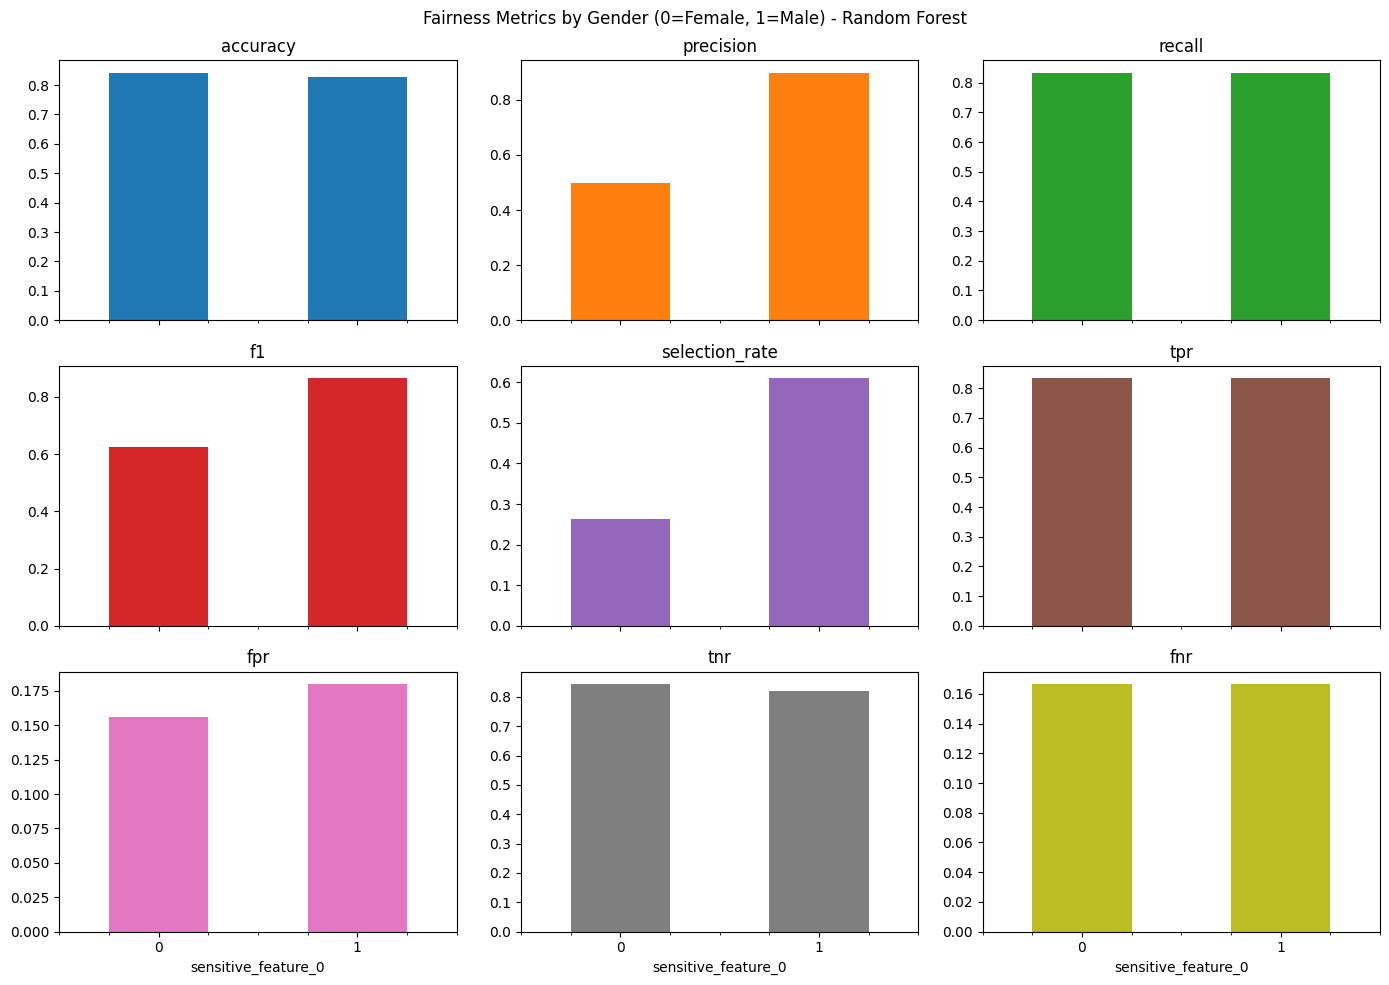


Between-group differences (max group − min group):
accuracy          0.013338
precision         0.398876
recall            0.000000
f1                0.239865
selection_rate    0.346431
tpr               0.000000
fpr               0.023750
tnr               0.023750
fnr               0.000000
dtype: float64

Between-group ratios (min / max):
accuracy          0.984161
precision         0.556250
recall            1.000000
f1                0.722656
selection_rate    0.431697
tpr               1.000000
fpr               0.868056
tnr               0.971852
fnr               1.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.4317
Equality of Opportunity Difference (TPR gap): 0.0000


In [17]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

## Fairness Metrics by Gender – Random Forest (RF)

This section analyzes the fairness of the **Random Forest classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8421     | 0.8288   |
| Precision        | 0.5000     | 0.8989   |
| Recall (Sensitivity) | 0.8333 | 0.8333   |
| F1 Score         | 0.6250     | 0.8649   |
| Selection Rate   | 0.2632     | 0.6096   |
| True Positive Rate (TPR) | 0.8333 | 0.8333 |
| False Positive Rate (FPR) | 0.1563 | 0.1800 |
| True Negative Rate (TNR) | 0.8438 | 0.8200 |
| False Negative Rate (FNR) | 0.1667 | 0.1667 |

---

### Between-Group Disparities

- **Precision Gap (0.40):** Male predictions are far more reliable than female ones.  
- **F1 Gap (0.24):** Overall predictive quality is much higher for males.  
- **Selection Rate Gap (0.35):** Males are more than twice as likely to receive positive predictions.  
- **Recall/TPR and FNR Gaps (0.00):** Sensitivity is perfectly balanced across genders.  
- **FPR/TNR Gaps (~0.024):** Slight differences exist, with males suffering marginally higher false positives.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.984 |
| Precision                 | 0.556 |
| Recall                    | 1.000 |
| F1 Score                  | 0.723 |
| Selection Rate            | 0.432 |
| TPR                       | 1.000 |
| FPR                       | 0.868 |
| TNR                       | 0.972 |
| FNR                       | 1.000 |

- **Selection Rate Ratio = 0.432 (< 0.8 rule)** → Indicates **strong disparate impact** against females.  
- **Precision Ratio = 0.56** → Female positive predictions are much less precise.  
- **Recall/TPR Ratio = 1.00** → Sensitivity is equal across genders.  
- **FPR/TNR Ratios (~0.87–0.97)** → Small disparities in negative error rates.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.4317**  
  → Females are far less likely to be classified as positive.  

- **Equality of Opportunity Difference (TPR gap): 0.0000**  
  → Perfect balance in sensitivity between genders.  

---

### Interpretation

The **Random Forest model reveals a mixed fairness profile**:  
- **Favors males** in outcome access and classification reliability (higher precision, F1, and selection rate).  
- **Treats genders equally in recall/TPR and FNR**, ensuring that positive cases are captured consistently across groups.  
- **Negligible differences in negative error rates (FPR/TNR)** suggest balanced treatment in this dimension.  

**Conclusion:**  
The RF model shows **systematic outcome bias against females** (low selection rate, low precision), but it achieves **perfect equality in sensitivity (TPR/FNR)**. This indicates that while females face barriers in receiving positive predictions, they are **not disadvantaged in terms of error rates for detecting positives**.

--

In [18]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_rf
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.966146
1                    0.899896

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.084921
1                    0.124677


## Group-Specific ROC-AUC and Brier Score – Random Forest (RF)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the Random Forest across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9661     | 0.8999   |
| Brier Score   | 0.0849     | 0.1247   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Females (0.966) outperform males (0.900), showing the model is **far better at distinguishing positives from negatives for females**.  
  - Although males also achieve strong performance (>0.89), there is a clear gap in favor of females.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.085) again outperform males (0.125).  
  - This means **predicted probabilities for females are more reliable and better calibrated**, while male predictions are less consistent.  

---

### Conclusion

The Random Forest model demonstrates a **fairness trade-off**:  
- In terms of **outcome access** (selection rate, precision, F1), males are strongly favored.  
- In terms of **probability quality** (ROC-AUC, Brier score), **females are favored**, benefiting from better discrimination and calibration.  

This highlights that **RF predictions are more trustworthy for females**, even though females are less frequently assigned positive outcomes.

---

### Bias detection for MLP

In [19]:
mlp_df = pd.read_csv("HeartFailureData_50_50_RecallFirstTunedMLP_predictions.csv")
print(mlp_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.976401       1
1    1       1  0.011376       0
2    1       1  0.839763       1
3    1       1  0.144366       0
4    0       0  0.204195       0


In [20]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["Sex"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.976401       1
1    1       1  0.011376       0
2    1       1  0.839763       1
3    1       1  0.144366       0
4    0       0  0.204195       0


In [21]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EOD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EOD - MLP
Demographic Parity Difference (MLP): 0.3980
Equalized Odds Difference (MLP): 0.1562


## Fairness Metrics – Multilayer Perceptron (MLP)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the MLP model.  

### Results
- **Demographic Parity Difference (DPD): 0.3980**  
- **Equalized Odds Difference (EOD): 0.1562**

---

### Interpretation

- **DPD (0.398):**  
  This relatively large value signals a **substantial imbalance in outcome distribution** across genders. Males (privileged group) are far more likely to receive positive predictions than females (unprivileged group). This represents **disparate impact** against females, limiting their access to favorable classifications.  

- **EOD (0.156):**  
  The equalized odds difference indicates a **noticeable disparity in error rates** (true positive rate and false positive rate) between genders. This means the model’s **classification errors are unevenly distributed**, with one gender experiencing different misclassification behavior than the other.  

---

### Conclusion

The MLP model shows **two dimensions of bias**:  
1. **Outcome disparity (DPD):** females are disadvantaged in terms of positive prediction rates.  
2. **Error-rate disparity (EOD):** sensitivity and error patterns differ between genders, making treatment inconsistent.  

Overall, the MLP introduces **bias both in access to positive outcomes and in classification fairness**, underscoring significant fairness concerns.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.868421   0.571429  0.666667  0.615385        0.184211   
1                    0.842466   0.929412  0.822917  0.872928        0.582192   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.666667  0.09375  0.90625  0.333333  
1                    0.822917  0.12000  0.88000  0.177083  


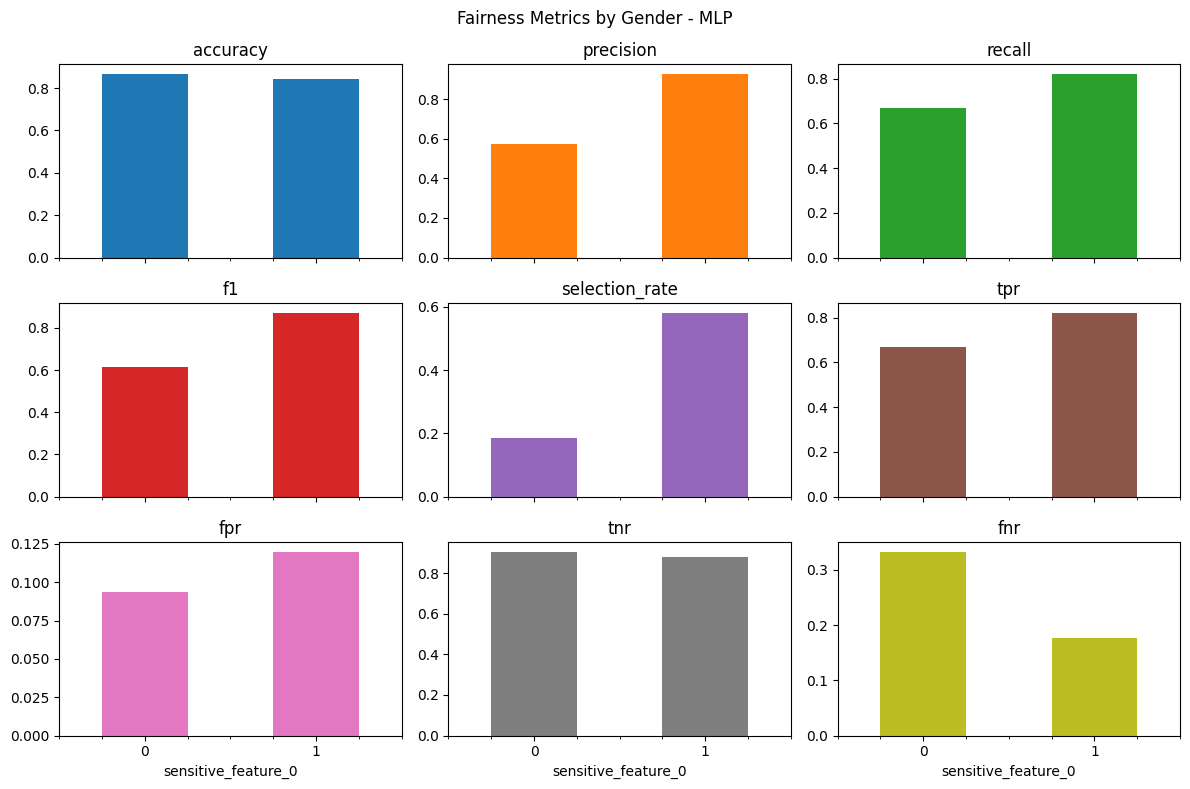


Between-group differences (max group − min group):
accuracy          0.025955
precision         0.357983
recall            0.156250
f1                0.257544
selection_rate    0.397981
tpr               0.156250
fpr               0.026250
tnr               0.026250
fnr               0.156250
dtype: float64

Between-group ratios (min / max):
accuracy          0.970112
precision         0.614828
recall            0.810127
f1                0.704966
selection_rate    0.316409
tpr               0.810127
fpr               0.781250
tnr               0.971034
fnr               0.531250
dtype: float64

Disparate Impact Ratio (selection rate): 0.3164
Equality of Opportunity Difference (TPR gap): 0.1562


In [22]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

## Fairness Metrics by Gender – Multilayer Perceptron (MLP)

This section analyzes the fairness of the **MLP classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8684     | 0.8425   |
| Precision        | 0.5714     | 0.9294   |
| Recall (Sensitivity) | 0.6667 | 0.8229   |
| F1 Score         | 0.6154     | 0.8729   |
| Selection Rate   | 0.1842     | 0.5822   |
| True Positive Rate (TPR) | 0.6667 | 0.8229 |
| False Positive Rate (FPR) | 0.0938 | 0.1200 |
| True Negative Rate (TNR) | 0.9063 | 0.8800 |
| False Negative Rate (FNR) | 0.3333 | 0.1771 |

---

### Between-Group Disparities

- **Precision Gap (0.36):** Positive predictions are far more reliable for males.  
- **Recall/TPR Gap (0.16):** Females are less likely to be correctly identified as positive.  
- **F1 Gap (0.26):** Overall predictive quality is significantly higher for males.  
- **Selection Rate Gap (0.40):** Males are over **3 times more likely** to receive positive predictions.  
- **FNR Gap (0.16):** Females experience substantially more missed positive cases (33% vs. 18%).  
- **FPR/TNR Gaps (~0.026):** Only minor disparities in negative error rates.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.970 |
| Precision                 | 0.615 |
| Recall                    | 0.810 |
| F1 Score                  | 0.705 |
| Selection Rate            | 0.316 |
| TPR                       | 0.810 |
| FPR                       | 0.781 |
| TNR                       | 0.971 |
| FNR                       | 0.531 |

- **Selection Rate Ratio = 0.316 (< 0.8 rule)** → Strong **disparate impact** against females.  
- **Precision Ratio = 0.615** → Female predictions are much less trustworthy.  
- **Recall/TPR Ratio = 0.81** → Females are less frequently detected when positive.  
- **FNR Ratio = 0.53** → Females miss far more true positives.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.3164**  
  → Females are much less likely to receive positive predictions compared to males.  

- **Equality of Opportunity Difference (TPR gap): 0.1562**  
  → Females are disadvantaged in sensitivity, with a sizable gap in detecting true positives.  

---

### Interpretation

The **MLP model heavily favors males**:  
- They receive many more positive predictions, with much higher precision and F1.  
- Females are disadvantaged across all outcome-oriented metrics: lower recall/TPR, higher FNR, and drastically lower selection rates.  
- While error rates for negatives (FPR/TNR) are nearly balanced, the **main fairness concern lies in outcome access and missed positives**.  

**Conclusion:**  
The MLP model introduces **systematic bias against females**, producing both **outcome bias (low selection rate, low precision, low F1)** and **error-rate bias (higher FNR, lower TPR)**.  
This aligns with the earlier **DPD (0.3980)** and **EOD (0.1562)**, confirming that MLP suffers from fairness issues in both outcome distribution and classification consistency.

---

In [23]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.916667
1                    0.899167

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.086751
1                    0.126320


## Group-Specific ROC-AUC and Brier Score – Multilayer Perceptron (MLP)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the MLP model across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

---

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9167     | 0.8992   |
| Brier Score   | 0.0868     | 0.1263   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Both groups achieve strong discrimination ability (>0.89).  
  - Females (0.917) outperform males (0.899), showing that the model is **slightly better at ranking positive and negative cases for females**.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.087) again outperform males (0.126).  
  - This means **probability predictions for females are more accurate and better calibrated**, while predictions for males are less reliable.  

---

### Conclusion

The MLP model demonstrates a **fairness trade-off**:  
- In terms of **outcome metrics** (selection rate, precision, F1), males are strongly favored.  
- In terms of **probability-based metrics** (ROC-AUC, Brier score), **females are favored**, as their predictions are more discriminative and better calibrated.  

This highlights that while **males gain more frequent and favorable classifications**, **females benefit from higher-quality probability estimates**.

---

## Comparison of Results

In [24]:
# Build results dict (same style as yours, just a few extra fields)
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("HeartFailureData_50M50F_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [25]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [26]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.4380,0.1875
DT,0.3306,0.1042
RF,0.3464,0.0237
MLP,0.3980,0.1562


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.8947     0.6667  0.6667  0.6667          0.1579  0.6667   
      1         0.8699     0.9425  0.8542  0.8962          0.5959  0.8542   
DT    0         0.8421     0.5000  0.6667  0.5714          0.2105  0.6667   
      1         0.8151     0.9367  0.7708  0.8457          0.5411  0.7708   
RF    0         0.8421     0.5000  0.8333  0.6250          0.2632  0.8333   
      1         0.8288     0.8989  0.8333  0.8649          0.6096  0.8333   
MLP   0         0.8684     0.5714  0.6667  0.6154          0.1842  0.6667   
      1         0.8425     0.9294  0.8229  0.8729          0.5822  0.8229   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.0625  0.9375  0.3333  
      1       0.1000  0.9000  0.1458  
DT    0       0.1250  0.8750  0.3333  
      1       0.1000  0.9000  0.2292  
RF    0       0.1562  0.8438  0.1667  
      1       0.1800  0.8200  0.1667  
MLP   0       0.0938  0.9062  0.3333  
      1       0.1200  0.8800  0.1771

## Overview of Fairness Metrics Across Models

The tables summarize **Demographic Parity Difference (DPD)**, **Equalized Odds Difference (EOD)**, and detailed **group-level performance metrics** for four models (**KNN, DT, RF, MLP**) across gender groups. Importantly, the training dataset was **balanced by gender (50:50)**, meaning disparities cannot be explained by sample imbalance but instead reflect **model learning behavior**.

---


## Fairness Metrics:
### Demographic Parity Difference (DPD)  
- **Range: 0.33 – 0.44** across models.  
- Values above 0.3 indicate **substantial outcome disparity**, where males consistently receive more positive classifications than females.  
- The **largest gap** occurs in KNN (0.438), while DT has the lowest (0.331), though still significant.  

**Interpretation:** Even with balanced training data, all models systematically favor males in outcome allocation.  

---

### Equalized Odds Difference (EOD)  
- **Range: 0.02 – 0.19** across models.  
- RF shows very low disparity (0.024), suggesting nearly equal error rates across genders.  
- KNN (0.188) and MLP (0.156) display the **highest imbalance in error distribution**, indicating different misclassification behaviors between genders.  

**Interpretation:** Some models (RF, DT) achieve more balanced error rates, while others (KNN, MLP) amplify disparities in sensitivity and false positives.  

---

### Group-Specific Performance  

#### Accuracy  
- Comparable across genders in all models (differences ~0.01–0.03).  
- Suggests overall correctness is not the main driver of bias.  

#### Precision  
- **Large gender gap in every model:**  
  - Females: ~0.50–0.67  
  - Males: ~0.90–0.94  
- Male predictions are consistently **more reliable** when labeled positive.  

#### Recall / TPR  
- Females consistently underperform in recall (0.67) compared to males (0.77–0.85).  
- This means **female positives are more often missed**, leading to higher **false negative rates** for females (up to 0.33).  

#### F1 Score  
- Substantially higher for males (0.85–0.90) than females (0.57–0.67).  
- Indicates males benefit from better **balanced predictive quality**.  

#### Selection Rate  
- Females: ~0.16–0.26  
- Males: ~0.54–0.61  
- Males are **2–3x more likely** to receive positive predictions.  

#### FPR and TNR  
- Differences are small (~0.02–0.04), with males slightly more prone to false positives in some models.  
- This imbalance is less critical than the disparities in **selection rate and recall**.  

---

### Key Insights  

- **Systematic Bias Against Females:**  
  Despite balanced training data, all models consistently:  
  - Assign **fewer positive predictions** to females (low selection rates).  
  - Deliver **lower-quality predictions** for females (low precision, recall, F1).  
  - Cause **higher false negative rates** for females, meaning their positive cases are missed more often.  

- **Male Advantage:**  
  - Males consistently benefit from **higher precision, higher recall, higher F1, and higher selection rates**, meaning they not only receive more positive predictions but also more reliable ones.  

- **Fairness Trade-Offs:**  
  - **Outcome fairness (DPD):** Poor across all models, consistently disadvantaging females.  
  - **Error-rate fairness (EOD):** Better in RF and DT, but worse in KNN and MLP.  

---

### Conclusion  

Even with **gender-balanced training data (50:50)**, strong disparities remain:  
- **Males are systematically favored** in outcome access and prediction quality.  
- **Females are disadvantaged** through lower selection rates, weaker precision and recall, and higher false negative rates.  
- The persistence of bias despite balanced data suggests that **model structures and decision boundaries amplify gender differences**, not just data imbalance.  

This highlights the need for **fairness interventions** (e.g., post-processing reweighting, in-processing constraints) to mitigate these systematic disparities.

---

In [27]:
# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.9531,0.9181
DT,0.8151,0.8786
RF,0.9661,0.8999
MLP,0.9167,0.8992


,Female (0),Male (1)
Model,,
KNN,0.0706,0.1133
DT,0.1431,0.1433
RF,0.0849,0.1247
MLP,0.0868,0.1263


## ROC-AUC and Brier Score by Gender Across Models  

The tables summarize **ROC-AUC** (discrimination ability) and **Brier score** (probability calibration) for each model (**KNN, DT, RF, MLP**) across genders:    

---

### 1. ROC-AUC (Higher = Better Discrimination)  
- **KNN:** Females (0.953) outperform males (0.918).  
- **DT:** Males (0.879) outperform females (0.815).  
- **RF:** Females (0.966) outperform males (0.900).  
- **MLP:** Females (0.917) slightly outperform males (0.899).  

**Interpretation:**  
- In three models (**KNN, RF, MLP**), the classifier is **better at ranking positives and negatives for females**.  
- Only in **DT** do males achieve higher discrimination ability.  
- Overall, ROC-AUC shows that **female predictions tend to have stronger discriminatory power**.  

---

### 2. Brier Score (Lower = Better Calibration)  
- **KNN:** Females (0.071) are better calibrated than males (0.113).  
- **DT:** Equal calibration across genders (~0.143).  
- **RF:** Females (0.085) are better calibrated than males (0.125).  
- **MLP:** Females (0.087) are better calibrated than males (0.126).  

**Interpretation:**  
- In most models (**KNN, RF, MLP**), probability predictions are **more reliable and better calibrated for females**.  
- Only **DT** shows no difference between genders.  
- Overall, females benefit from **higher-quality probability estimates**.  

---

### Key Insights  

- **Discrimination vs. Calibration:**  
  - Females generally achieve **higher ROC-AUC and lower Brier scores**, indicating **better model reliability and probability quality**.  
  - Males do not consistently outperform in either metric, except in **DT’s ROC-AUC**.  

- **Fairness Trade-Off:**  
  - While outcome-based metrics (selection rate, precision, F1) consistently favored males (see previous tables),  
  - Probability-based metrics (**ROC-AUC, Brier**) consistently favor **females**, suggesting their predictions are of **higher quality when produced**, even though they are less frequent.  

---

### Conclusion:  

Across models, **female predictions are generally more discriminative and better calibrated** than male predictions.  
This reveals a **fairness paradox**:  
- **Males are advantaged in outcome access and reliability of classifications**,  
- **Females are advantaged in probability quality and discrimination ability**.  

Such divergence highlights the importance of evaluating **both outcome-based fairness metrics (DPD, EOD, group metrics)** and **probability-based metrics (ROC-AUC, Brier)** to capture the full picture of gender bias in machine learning models.  

---

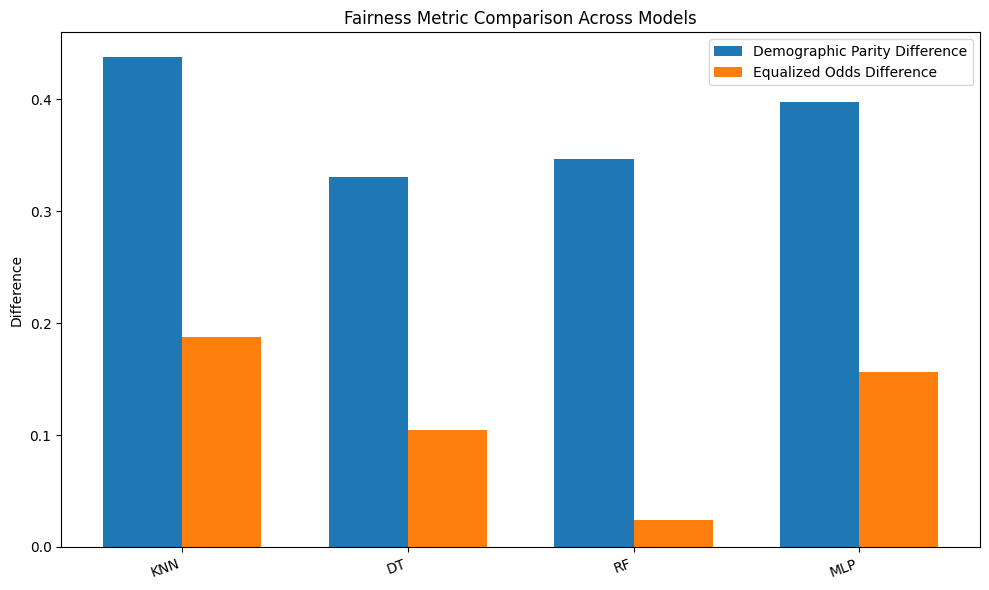

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

## Fairness Metric Comparison Across Models  

The figure compares **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** across four models: **KNN, DT, RF, and MLP**.  

---

### Interpretation of DPD (Blue Bars)  
- **KNN (~0.44)** and **MLP (~0.40):** Show the largest DPD values, indicating strong disparities in outcome distribution. Males receive positive predictions much more often than females.  
- **RF (~0.35):** Displays a moderate disparity, still disadvantaging females in outcome access.  
- **DT (~0.33):** Has the lowest DPD among models, but the gap is still considerable.  

**Insight:** All models suffer from **substantial outcome imbalance**, with females systematically under-selected.  

---

### Interpretation of EOD (Orange Bars)  
- **KNN (~0.19):** Shows the highest EOD, indicating large differences in error rates (true positives and false positives) between genders.  
- **MLP (~0.16):** Also displays notable error-rate disparities.  
- **DT (~0.10):** Shows moderate error-rate imbalance.  
- **RF (~0.02):** Nearly zero EOD, suggesting **almost equal error distribution across genders**.  

**Insight:** Some models, especially RF, treat genders more consistently in terms of misclassification, while KNN and MLP produce significant error-rate disparities.  

---

### Overall Conclusion  
- **Demographic Parity Difference (DPD):** High across all models → females receive consistently fewer positive predictions.  
- **Equalized Odds Difference (EOD):** Varies strongly → RF achieves nearly equal treatment in terms of error rates, while KNN and MLP show significant error-rate imbalances.  

This means:  
- **Outcome fairness (DPD)** is problematic in all models, disadvantaging females.  
- **Error-rate fairness (EOD)** is model-dependent: RF achieves near parity, while KNN and MLP amplify gender disparities.  

---

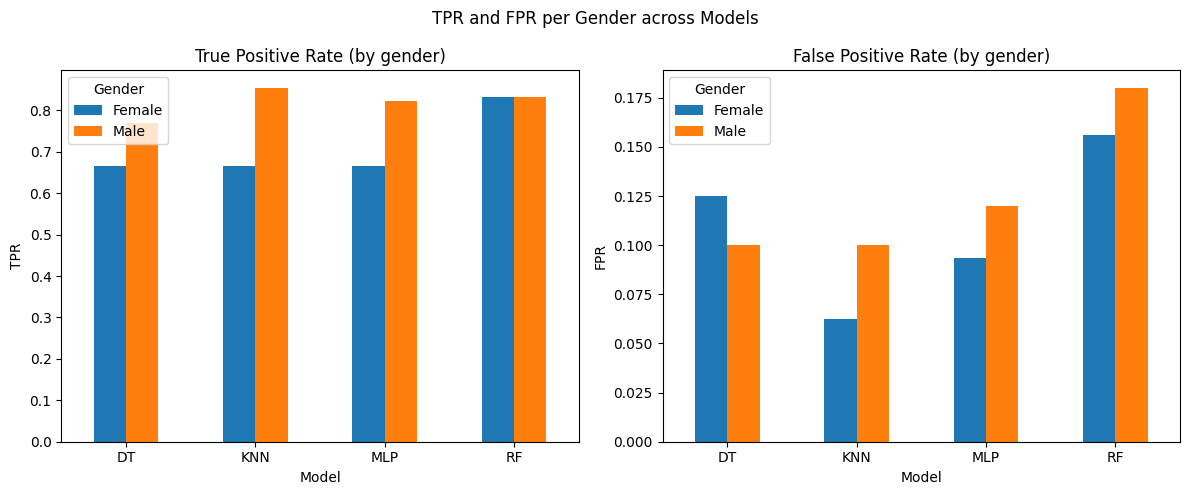

In [29]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## TPR and FPR per Gender Across Models  

The figure compares **True Positive Rate (TPR)** and **False Positive Rate (FPR)** across gender groups for four models: **DT, KNN, MLP, and RF**.  
- **Blue = Female (Unprivileged group)**  
- **Orange = Male (Privileged group)**  

---

### True Positive Rate (TPR) – Left Plot  
- **DT:** Males (~0.75) have a higher TPR than females (~0.67).  
- **KNN:** Males (~0.85) significantly outperform females (~0.67), the **largest TPR gap** across models.  
- **MLP:** Males (~0.82) outperform females (~0.67).  
- **RF:** Both genders (~0.83) achieve **equal TPR**, showing no disparity.  

**Insight:**  
- For most models, **females are less likely to be correctly identified as positives**, meaning more missed positive cases.  
- **RF is the only model achieving equal opportunity in TPR** across genders.  

---

### False Positive Rate (FPR) – Right Plot  
- **DT:** Females (~0.125) slightly higher than males (~0.10).  
- **KNN:** Females (~0.06) lower than males (~0.10).  
- **MLP:** Females (~0.09) lower than males (~0.12).  
- **RF:** Females (~0.16) lower than males (~0.18).  

**Insight:**  
- In most models, **males experience slightly higher false positive rates** than females, except in DT where females face slightly higher FPR.  
- This suggests that while males benefit from higher TPR (more positives captured), they also tend to suffer more false positives in several models.  

---

### Overall Conclusion  

- **TPR (Equal Opportunity):**  
  - Males generally benefit from **higher sensitivity (TPR)**, especially in KNN and MLP.  
  - Females face more missed positives, except in RF, which achieves perfect parity.  

- **FPR (Error Balance):**  
  - Males usually have **higher FPR** than females, indicating more false alarms.  
  - The exception is DT, where females experience slightly more false positives.  

**Fairness Perspective:**  
- Models often **favor males in positive detection (TPR advantage)**, but at the cost of slightly **higher false positives (FPR disadvantage)**.  
- RF achieves the best fairness trade-off by balancing both TPR and FPR across genders.  

---

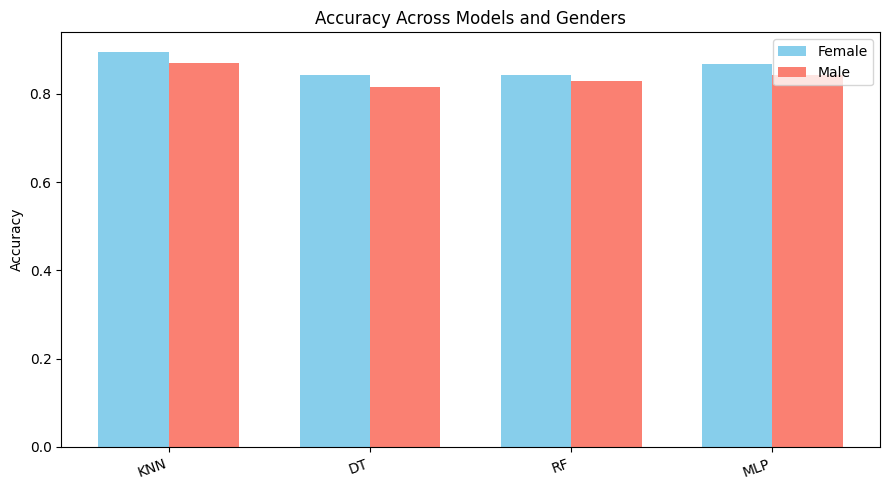

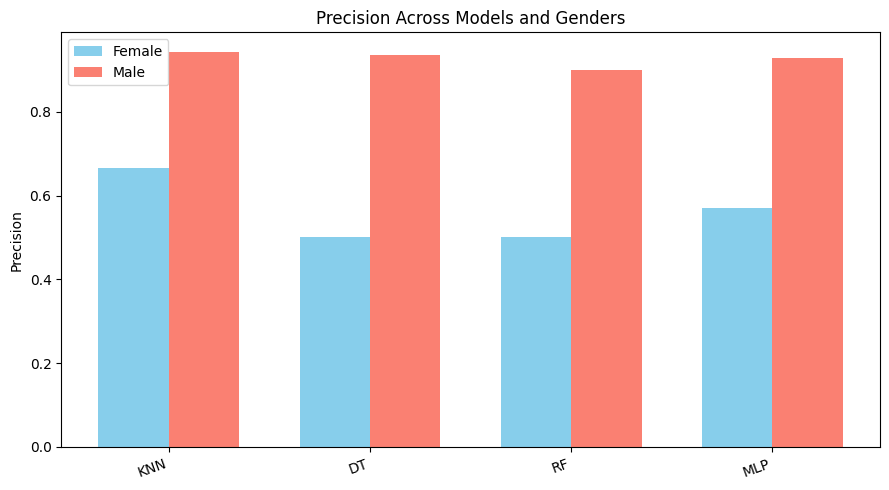

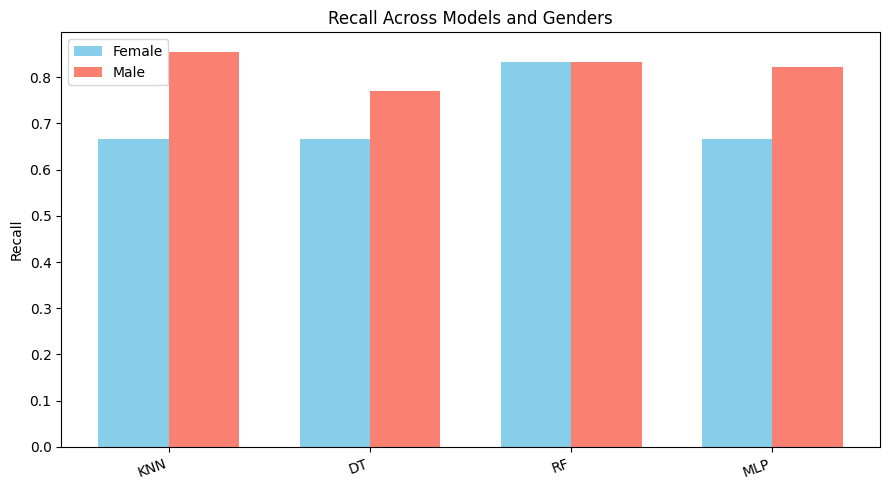

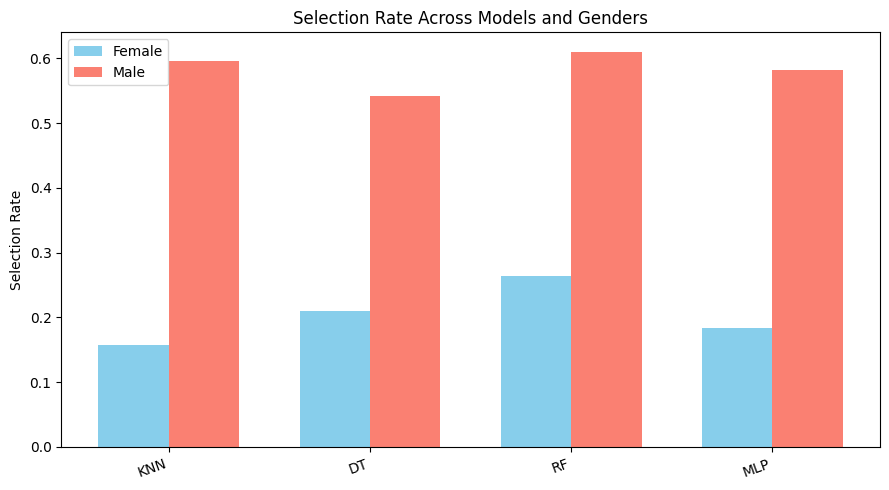

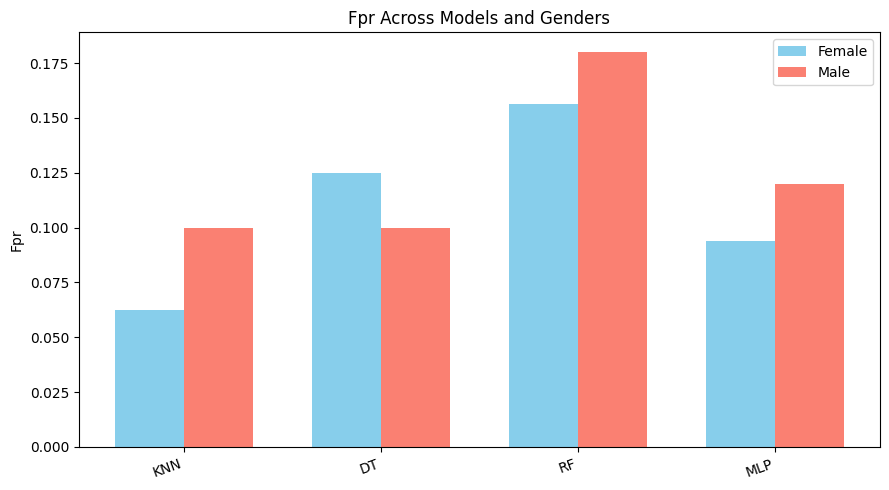

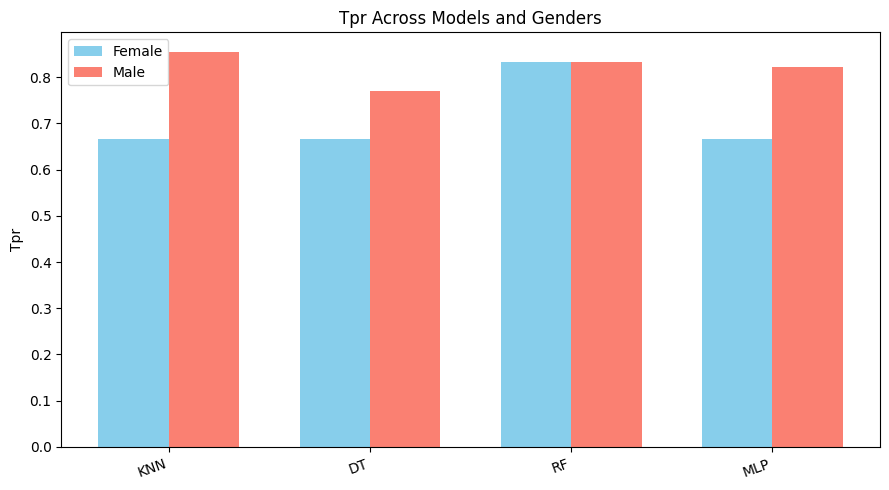

In [30]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Gender-Specific Performance Across Models  

The plots compare **accuracy, precision, recall, selection rate, FPR, and TPR** for females (blue) and males (orange) across four models: **KNN, DT, RF, and MLP**.  

---

### 1. Accuracy  
- Accuracy is **comparable across genders** for all models (differences <0.03).  
- This suggests that overall correctness does not strongly vary by gender.  

**Insight:** Accuracy alone hides fairness disparities, since other metrics show much larger gaps.  

---

### 2. Precision  
- **Males consistently outperform females** in precision across all models.  
  - Male precision: ~0.90–0.95  
  - Female precision: ~0.50–0.67  
- This means male positive predictions are far more reliable than female ones.  

**Insight:** Female-labeled positives are much more prone to being false alarms.  

---

### 3. Recall  
- **Males achieve higher recall** than females in KNN, DT, and MLP.  
- In RF, recall is balanced across genders (~0.83).  

**Insight:** Female positives are more often missed, except in RF which achieves equal sensitivity.  

---

### 4. Selection Rate  
- **Males are 2–3x more likely** to be classified as positive across all models.  
  - Female rates: ~0.16–0.26  
  - Male rates: ~0.54–0.61  
- This disparity reflects the **strong demographic parity differences** observed in fairness metrics.  

**Insight:** Females have systematically reduced access to positive outcomes.  

---

### 5. False Positive Rate (FPR)  
- Mixed patterns:  
  - **Higher for males** in KNN, RF, and MLP.  
  - **Higher for females** in DT.  
- Differences remain moderate (~0.02–0.06).  

**Insight:** While males usually suffer slightly more false positives, this does not outweigh their advantages in recall and precision.  

---

### 6. True Positive Rate (TPR)  
- **Males have consistently higher TPR** in KNN, DT, and MLP.  
- **RF achieves perfect parity**, with equal TPR across genders.  

**Insight:** Females face more missed positives (lower TPR), except in RF which balances sensitivity.  

---

### Overall Interpretation  

- **Outcome Bias:**  
  - Males consistently benefit from higher precision, recall, F1, and selection rates.  
  - Females are disadvantaged in both the quantity (selection rate) and quality (precision, recall) of positive predictions.  

- **Error Patterns:**  
  - Males often incur more false positives, but this disadvantage is minor compared to the consistent female disadvantage in false negatives (missed positives).  
  - RF stands out by balancing **TPR** across genders, though it still shows strong disparities in **precision and selection rate**.  

- **Fairness Implication:**  
  - The models replicate a pattern of **systematic female disadvantage**: fewer positive predictions, less reliable positives, and more missed cases.  
  - This confirms the earlier fairness metrics (high DPD and moderate-to-high EOD), showing **structural gender bias** despite balanced training data.  


--